## Нейросети - основы.
### Ноутбук составлен по воспоминаниям из разных курсов

Попробуем сделать нейрон. n входов, 1 выход, от n входов сигнал передается с весами w, в самом нейроне действует функция активации, работающая с суммой сигналов от входов. Для начала воспользуемся классической сигмоидой. 

Пока без numpy, на чистом python

In [1]:
import math

In [2]:
def sigm(x):
    # print(x)
    return 1 / (1 + math.exp(-x))

In [3]:
import matplotlib.pyplot as plt

In [4]:
X = [x for x in range(-10, 10)]

In [5]:
Y = [sigm(x) for x in X]

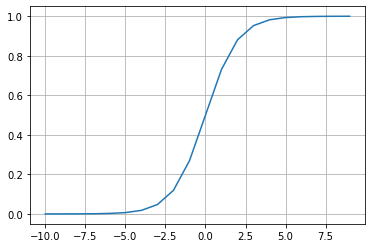

In [6]:
plt.plot(X, Y)
plt.grid()
plt.show()

In [7]:
class Neuron:
    
    def __init__(self, n, activation):
        self.w = [0.5 for i in range(n)] # будем пока пользоваться статической инициализацией весов
        self.act = activation
        
    def forward(self, X):
        result = 0
        for x, w in zip(X, self.w):
            result += x*w
        return self.act(result)

Пусть будет 2 признака, подаваемыми на вход нейрону

In [8]:
X = [-4, 4]

In [9]:
N1 = Neuron(2, sigm)

In [10]:
N1.forward(X)

0.5

В направлении forward работает - теперь нейрон нужно обучить. Возьмем задачу классификации и логистическую функци потерь:

In [11]:
def logloss(y, y_hat):
    eps = 1e-10
    return -y*math.log(y_hat + eps, 2) - (1 - y)*math.log(1 - y_hat + eps, 2)

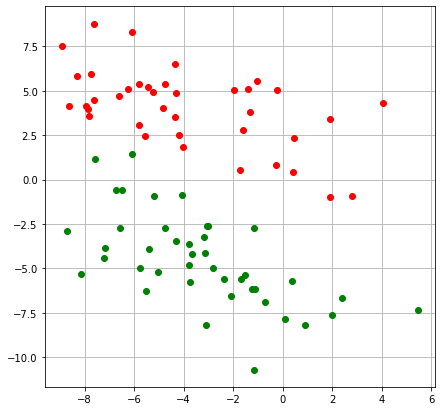

In [12]:
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
import numpy as np

X, Y = make_classification(n_samples=100, n_features=2, 
                           n_informative=2, n_classes=2, 
                           n_redundant=0,
                           n_clusters_per_class=1,
                           scale = 4)

# X, Y = make_classification(n_samples=100, n_features=2, 
#                            n_informative=2, n_classes=2, 
#                            n_redundant=0,
#                            n_clusters_per_class=2)

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=20, random_state = 42)

fig = plt.figure(figsize=(7, 7))

plt.plot(X_train[np.where(Y_train==0), 0], X_train[np.where(Y_train==0), 1], 'ro')
plt.plot(X_train[np.where(Y_train==1), 0], X_train[np.where(Y_train==1), 1], 'go')
plt.grid()

plt.show()

Посмотрим, как выглядит функция ошибки в зависимости от весов w1 и w2

In [13]:
import pylab
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

/tmp/ipykernel_29240/3867622622.py:21: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.
  axes = Axes3D(fig)


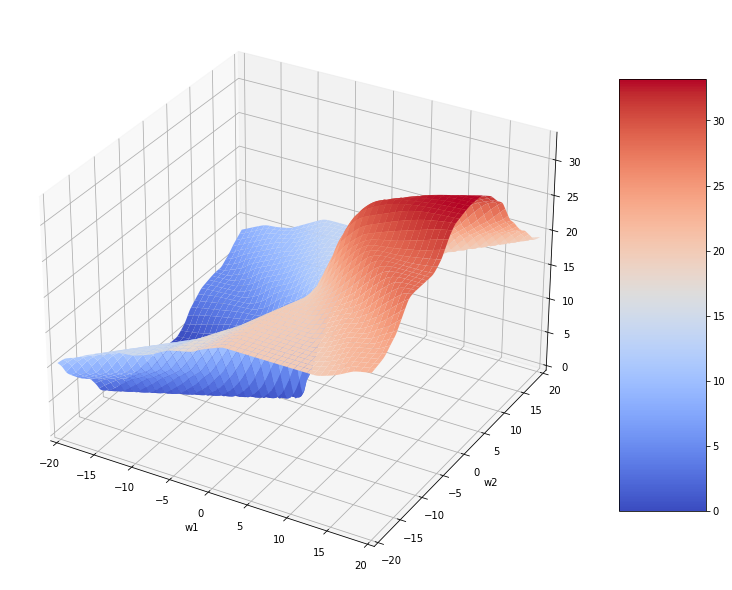

In [14]:
def makeData(X_train, Y_train):
    W1 = np.arange (-20, 20, 0.2)
    W2 = np.arange (-20, 20, 0.2)
    w1grid, w2grid = np.meshgrid(W1, W2)
    
    lossgrid = np.zeros((len(W1), len(W2)))
    for i, w1 in enumerate(W1):
        for j, w2 in enumerate(W2):
            N = Neuron(2, sigm)
            N.w = [w1, w2]
            result = []
            for x, y in zip(X_test, Y_test):
                y_hat = N.forward(x)
                result.append(logloss(y, y_hat))
            lossgrid[i, j] = sum(result) / len(result)

    return w1grid, w2grid, lossgrid

x, y, U = makeData(X_train, Y_train)
fig = pylab.figure(figsize=(10, 12))
axes = Axes3D(fig)
axes.set_xlabel('w1')
axes.set_ylabel('w2')
axes.set_xlim(-20, 20)
axes.set_ylim(-20, 20)
surf = axes.plot_surface(x, y, U, cmap=cm.coolwarm)
fig.colorbar(surf, shrink=0.5, aspect=5)
# axes.plot_wireframe(x, y, U)
pylab.show()

In [15]:
U.min()

-1.4373276589080095e-10

Необходимо подобрать веса w1 и w2 так, чтобы минимизировать функцию ошибки. На графике выше видно, что минимум находится в районе точки [0, 0]. Если мы инициализируем веса любыми значениями, отличными от оптимальных, необходимо изменять их таким образом, чтобы значение функции ошибки на обучающей выборке снижалось. Оптимальным изменением весов с целью снижения значения функции будет снижение в направлении, противоположном градиенту функции в данной точке. 

Градиент - это вектор-функция, координатами которой являются частные производные. Почему вектор? Потому, что имеет координаты по числу переменных. Почему функция? Потому, что эти координаты зависят от переменных. Градиент функции потерь, представленной на трехмерном графике выше, - это вектор в плоскости (w1, w2).

### $$ gradL(w1, w2) = \left( \frac{\partial(L(w1, w2))}{\partial(w1)}, \frac{\partial(L(w1, w2))}{\partial(w2)} \right) $$
Частные производные показывают скорость роста функции по направлению соответствующей оси. Быстрее всего функция в точке растет в направлении своего градиента. Соответственно, чтобы добиться оптимального снижения значения функции, необходимо двигаться в направлении антиградиента. Как это сделать? Найти частные производные функции потерь по w1 и w2 и двигаться в пространстве (w1, w2) в противоположном этим частным производным направлении шагами определенной величины (learning rate). Это и есть метод градиентного спуска.

Проблема в том, что функция потерь зависит не только от w1 и w2, но и от обучающей выборки. Если бы зависимость от каких-либо переменных, кроме w1 и w2, отсутствовала, мы могли бы аналитически вычислять значение градиента в каждой точке. Или вообще нашли бы значение минимума функции по w1 и w2, приравняв к нулю частные производные. Вместо этого частные производные по переменным придется вычислять, рассчитывая значение функции потерь по обучающей выборке в каждой интересующей нас точке. 

### $$ logloss(y, \hat y) =  -ylog_2(\hat y) - (1-y)(log_2(1-\hat y)) = $$
### $$ = -ylog_2(\frac{1}{1+e^{-(x_1w_1 + x_2w_2)}}) - (1-y)log_2(1- \frac{1}{1+e^{-(x_1w_1 + x_2w_2)}})$$

Частные производные функции потерь по w1 и w2 равны:
### $$\frac{\partial logloss(y, \hat y)}{\partial w_1} = \frac{x_1}{ln2}\left( \frac{1}{1+e^{-(x_1w_1 + x_2w_2)}} - y\right)$$
### $$\frac{\partial logloss(y, \hat y)}{\partial w_2} = \frac{x_2}{ln2}\left( \frac{1}{1+e^{-(x_1w_1 + x_2w_2)}} - y\right)$$
В скобках - разность между выходом нейрона и действительным значением зависимой переменной. Реализуем метод градиентного спуска, пока не стохастический, рассчитывая на каждом шаге эту разность по всем элементам выборки и усредняя ее. Намеренно инициализируем веса нейрона значениями, дающими высокий уровень функции потерь:

In [16]:
def accuracy(Y, Y_hat):
    errors = 0
    for y, y_hat in zip(Y, Y_hat):
        if round(y_hat) != y:
            errors += 1
    return (len(Y) - errors) / len(Y)

In [17]:
N1 = Neuron(2, sigm)
N1.w = [-10, 10]

In [18]:
def gDescent(X_train, Y_train, N1, lr = 0.1, criterion = 0.01):
    curr_loss = 1e3
    iteration = 0
    while abs(curr_loss) > criterion and iteration < 50:
        diff = []
        losses = []
        Y_hat = []
        for x, y in zip(X_train, Y_train):
            y_hat = N1.forward(x)
            Y_hat.append(y_hat)
            losses.append(logloss(y, y_hat))
            dw1 = (-1) * lr * x[0] / math.log(2) * (y_hat - y) # Домножаем на -1, так как нужно двигаться в направлении против градиента
            dw2 = (-1) * lr * x[1] / math.log(2) * (y_hat - y) # Домножаем на -1, так как нужно двигаться в направлении против градиента
            N1.w[0] += dw1
            N1.w[1] += dw2
        curr_loss = sum(losses) / len(losses)
        acc = accuracy(Y_train, Y_hat)
        
        print(f'\niteration {iteration}: curr_loss = {curr_loss}, accuracy = {acc} dw1 = {dw1}, dw2 = {dw2}')
        print(f'new weights: {N1.w}')
        
        iteration += 1
    

In [19]:
gDescent(X_train, Y_train, N1, lr = 0.01)


iteration 0: curr_loss = 20.592226357101758, accuracy = 0.3125 dw1 = -1.3173231879048557e-15, dw2 = -8.113416834014415e-16
new weights: [-8.077037138409004, 5.913311266773844]

iteration 1: curr_loss = 18.073951803513122, accuracy = 0.3625 dw1 = -3.0044213057479163e-16, dw2 = -1.8504284007401298e-16
new weights: [-5.9387664757779275, 2.099751506915994]

iteration 2: curr_loss = 11.727477182183362, accuracy = 0.5 dw1 = -1.608520945231192e-14, dw2 = -9.906908976270234e-15
new weights: [-3.5711162713911624, -0.8404573141221546]

iteration 3: curr_loss = 3.577689742723778, accuracy = 0.7125 dw1 = -2.660103068642645e-11, dw2 = -1.6383621889830005e-11
new weights: [-1.6162993366928686, -2.3465884771860193]

iteration 4: curr_loss = 0.2443936101377902, accuracy = 0.9375 dw1 = -3.115724021877979e-10, dw2 = -1.9189799406365335e-10
new weights: [-1.1188819220851838, -2.6004279926981164]

iteration 5: curr_loss = 0.08423249422084404, accuracy = 0.975 dw1 = -5.664639004618842e-10, dw2 = -3.488861

In [20]:
class PrimitiveNN:
    
    def __init__(self, Neuron):
        self.N = Neuron
        
    def predict(self, X_test):
        result = []
        for x in X_test:
            result.append(round(self.N.forward(x)))
        return np.array(result)

In [21]:
primNN = PrimitiveNN(N1)

In [22]:
from mlxtend.plotting import plot_decision_regions

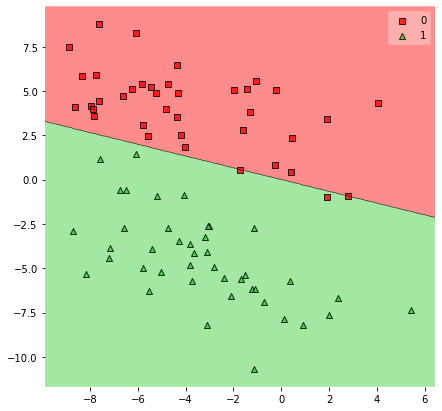

In [23]:
fig = plt.figure(figsize=(7, 7))
plot_decision_regions(X_train, Y_train, primNN, colors = 'red,limegreen,blue,gray,cyan')
plt.show()